<a href="https://colab.research.google.com/github/bala-codes/SEO-Words-Scrapper-based-on-google-search-text/blob/master/Scrapper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import time
start_time1 = time.time()
!pip install google
!pip install wordcloud
import requests
from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
import collections
import string
import nltk
nltk.download('stopwords')
nltk.download('words')
from nltk.corpus import stopwords
stop = stopwords.words('english')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from wordcloud import WordCloud
import collections
import matplotlib.pyplot as plt
%matplotlib inline

import requests
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import warnings

warnings.filterwarnings('ignore', message='Unverified HTTPS request')
from bs4 import BeautifulSoup

print("All Packages Imported Successfully")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

All Packages Imported Successfully


In [26]:
def text_to_google():
    try: 
        from googlesearch import search 
    except ImportError:  
        print("No module named 'google' found") 
        
    searchtext = input("Enter the Text : ")
    #query = "digital marketing company"
    
    import requests, json
    URL="http://suggestqueries.google.com/complete/search?client=firefox&q={}".format(searchtext)

    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.70 Safari/537.36'}

    response = requests.get(URL, headers=headers)
    result = json.loads(response.content.decode('utf-8'))
    print(result)
    if len(result[1]) != 0:
        query = result[1]
    else:
        query = [result[0]]

    j = []
    for k in range(len(query)):
        try: 
            from googlesearch import search 
        except ImportError:  
            print("No module named 'google' found") 
        for i in search(query[k], tld = "co.in", lang='en', stop=18, pause = 2.0): 
            j.append(i) 
    j = list(set(j))
    print(j)
    print("Number of Links Captured :",len(j))


    datas = []
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Safari/537.36'}

    for i in j:
        try:
          print(i)  
          response = requests.get(i, headers = headers, verify=False)
          
        except:
          print("Exception Occured Whilst Visiting One of the Website")
          continue

        soup = BeautifulSoup(response.text, "html.parser")
        title = str(soup.find_all('title'))
        title = re.sub(r"<.*?>","",title)
        # title = str(title[0]).replace("<title>","").replace("</title>", "")

        metas = soup.find_all('meta')
        description =  [ meta.attrs['content'] for meta in metas if 'name' in meta.attrs and ( (meta.attrs['name'] == 'Description') or (meta.attrs['name'] == 'description') ) ]
        keyword = [ meta.attrs['content'] for meta in metas if 'name' in meta.attrs and ( (meta.attrs['name'] == 'Keywords') or (meta.attrs['name'] == 'keywords') ) ]

        if(len(description) == 0):
            description = "None"

        if(len(keyword) == 0):
            keyword = "None"

        if(len(title) == 0):
            title = "None"

        data = {"url" : i, "title" : title, "description" : description, "keyword" : keyword}
        
        if(description != "None" and keyword != "None"):
            datas.append(data)
        else:
            continue
    #print(datas)
    return datas

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn):  
    sorted_items = sorted_items[:topn]
    results=[]
   
    # word index, count i
    for idx, count in sorted_items:    
        # get the ngram name
        n_gram=feature_names[idx]
        # collect as a list of tuples
        results.append((n_gram,count))
    return results

def n_grams(df, topn):
  df['content'] = df['title'] + " " + df['description'][0] + " " + df['keyword'][0]
  df['content'] = df['content'].str.replace('None', '')
  df['content'] = df['content'].str.replace('[^a-zA-Z]', ' ')
  df['content'] = df['content'].apply(lambda x: x.lower())
  df['content'] = df['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

  x = df['content'].values

  ##################################################################

  count_vectorizer = CountVectorizer(stop_words = "english")
  count_train = count_vectorizer.fit_transform(x)

  sorted_items1=sort_coo(count_train[0].tocoo())
  feature_names1=count_vectorizer.get_feature_names()

  n_grams1 = extract_topn_from_vector(feature_names1 ,sorted_items1 , topn = topn)

  #################################################################

  tfidf_vectorizer = TfidfVectorizer(stop_words = "english")
  tfidf_train = tfidf_vectorizer.fit_transform(x)

  sorted_items2=sort_coo(tfidf_train[0].tocoo())
  feature_names2=tfidf_vectorizer.get_feature_names()

  n_grams2 = extract_topn_from_vector(feature_names2 ,sorted_items2 ,topn = topn)
  return n_grams1, n_grams2

def plotter(df):
  import matplotlib.pyplot as plt
  %matplotlib inline
  from wordcloud import WordCloud
  import collections

  df['content'] = df['content'].astype(str)
  all_words = []

  for line in list(df['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))):
    
    words = line.split()
    for word in words:
      all_words.append(word.lower())

  plt.figure(figsize=(12,5))
  print()
  plt.title('Top 25 most commmon words')
  print()
  plt.xticks(fontsize=15,rotation=90)
  fd = nltk.FreqDist(all_words)
  fd.plot(25)
  plt.show()
  print()
  print()

  import matplotlib.pyplot
  wordfreq = collections.Counter(all_words)
  wordcloud = WordCloud(background_color="white", stopwords=stopwords,contour_color='firebrick',width=1600, height=900, colormap=matplotlib.cm.inferno).generate_from_frequencies(wordfreq)
  
  plt.figure(figsize=(19,15))
  print()
  plt.title('Word Cloud of Important Words')
  print()
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()
  print()
  print()
  
  key = []
  for i,k in wordfreq.items():
    key.append(i)
  return key

def table(df):
  a,b = n_grams(df, 35)
  df1 = pd.DataFrame(a, columns =['WORDS_N', 'COUNT']) 
  df2 = pd.DataFrame(b, columns =['WORDS_F', 'FREQUENCY']) 
  dftemp = pd.DataFrame(pd.concat([df1,df2], axis = 1))
  return dftemp

# load the whole embedding into memory
import numpy as np
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

embeddings_index = dict()
embedding_dims = []

# GET WORD VECTORS FROM HERE --> http://nlp.stanford.edu/data/glove.6B.zip
f = open('/content/drive/My Drive/Colab Notebooks/TEXT EMBEDDINGS FILES/Glove_Embedding/glove.6B.300d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Loaded %s word vectors.' % len(embeddings_index))
################################################################################
from scipy import spatial
def find_closest_embeddings(embedding):
    return sorted(embeddings_index.keys(), key=lambda word: spatial.distance.euclidean(embeddings_index[word], embedding))

def similar_words(number , words):
  filtered_sentence = []
  alternate = words
  genwords = set(nltk.corpus.words.words())
  filtered_sentence = [w for w in alternate if w.lower() in genwords]
  filtered_sentence = [w for w in filtered_sentence if not w.isdigit()] 

  num = int(number)
  embedding = []
  embedding = filtered_sentence

  
  if len(embedding) == 1:
    print(color.BOLD + str(embedding) + color.END)
    temp1 = []
    temp1 = find_closest_embeddings(embeddings_index[embedding[0]])[1:]              # [1:30]
    y = []
    for k in range(len(temp1)):
      if temp1[k].isalpha() == True:
        y.append(temp1[k])

    y = [w for w in y if w.lower() in genwords] #
    y = [w for w in y if w.lower() not in stop] #
    y = [w for w in y if not w.isdigit()] #
    print(y[:num])

  else: 
    for i in range(len(embedding)):
      print(color.BOLD + embedding[i] + color.END)
      temp2 = []
      temp2 = find_closest_embeddings(embeddings_index[embedding[i]])[1:]            # [1:30]
      y = []
      for j in range(len(temp2)):
        if temp2[j].isalpha() == True:
          y.append(temp2[j])
      
      y = [w for w in y if w.lower() in genwords] #
      y = [w for w in y if w.lower() not in stop] #
      y = [w for w in y if not w.isdigit()] #
      print(y[:num])
      print()


Loaded 400000 word vectors.


# ENTER THE GOOGLE SEARCH TERMS HERE

In [28]:
import time
start_time = time.time()

df = pd.DataFrame() 
tables = pd.DataFrame()

datas = text_to_google()
df = pd.DataFrame(datas)
tables = table(df)
print("--- %s minutes ---" % ((time.time() - start_time)/60))
tables
# website development in coimbatore

Enter the Text : website development in coimbatore
['website development in coimbatore', ['website development in coimbatore', 'website development company in coimbatore', 'e-commerce website development in coimbatore', 'website design and development in coimbatore', 'website development services coimbatore', 'ecommerce website development company in coimbatore', 'best website development company in coimbatore', 'ecommerce website development services in coimbatore'], [], {'google:suggestsubtypes': [[], [22, 30], [22, 30], [22, 30], [22, 30], [22, 30], [22, 30], [22, 30]]}]
['https://avanexa.com/', 'https://avanexa.com/about-us', 'https://www.pgsoftwares.com/website-designing-company-coimbatore-india.html', 'https://www.clouddreams.in/about-us.html', 'https://webnox.in/website-designing-price-coimbatore/', 'https://www.justdial.com/Coimbatore/Ecommerce-Website-Development-Services-in-Ramanathapuram-Coimbatore/nct-11027448', 'https://propluslogics.com/ecommerce-development/', 'https://w

,WORDS_N,COUNT,WORDS_F,FREQUENCY
0,website,22,website,0.498202
1,india,18,india,0.407620
2,designing,17,designing,0.384974
3,company,17,company,0.384974
4,design,14,design,0.317038
5,coimbatore,14,coimbatore,0.317038
6,web,10,web,0.226455
7,professional,5,professional,0.113228
8,services,4,services,0.090582
9,best,4,best,0.090582


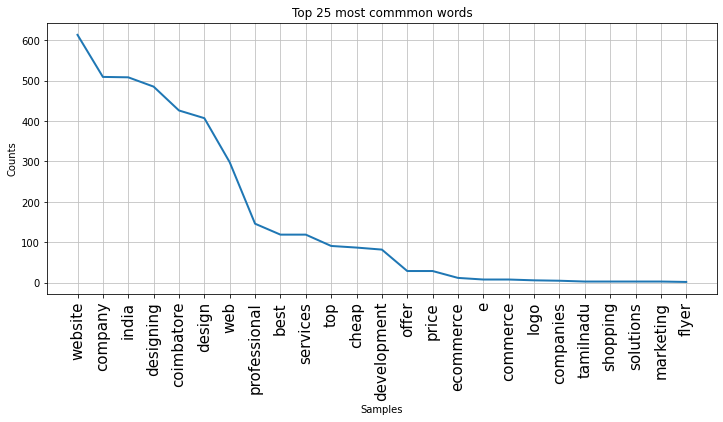

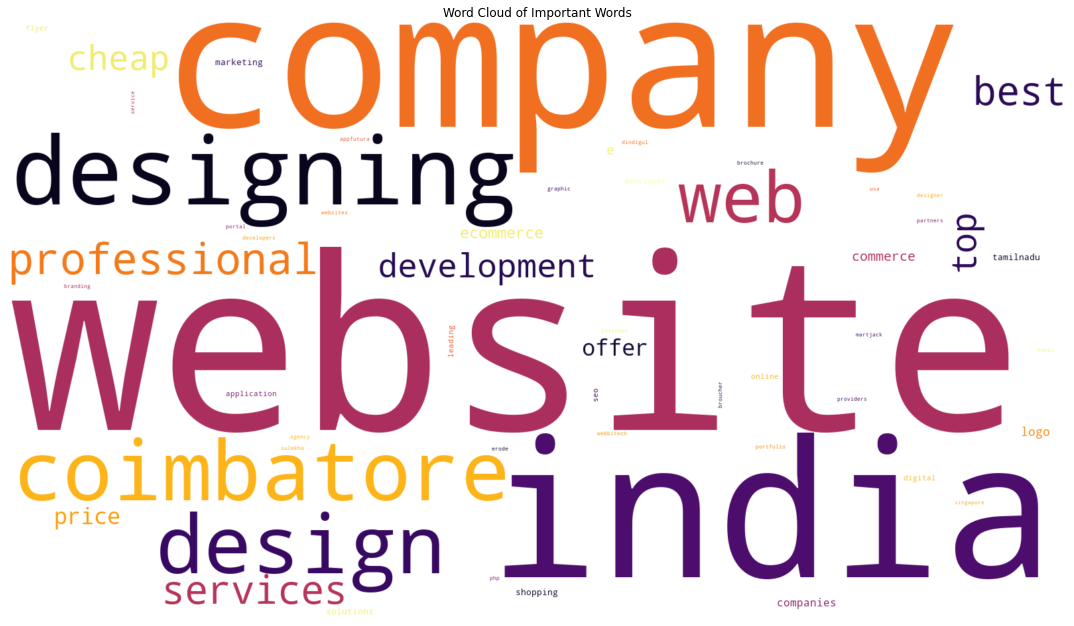



THE MOST SIMILAR WORDS FOR THE TOP KEYWORDS ARE :

designing
['design', 'besides', 'innovative', 'transforming', 'addition', 'begun', 'combining', 'designer', 'instance', 'simultaneously', 'working', 'instead', 'making', 'perfecting', 'experimented']

company
['subsidiary', 'firm', 'business', 'venture', 'bought', 'manufacturer', 'based', 'addition', 'corporation', 'instance', 'industry', 'acquired', 'sell', 'recently', 'example']

web
['site', 'instance', 'page', 'search', 'user', 'portal', 'example', 'content', 'available', 'addition', 'information', 'simply', 'find', 'video', 'explaining']

design
['designed', 'designing', 'architecture', 'concept', 'architectural', 'innovative', 'original', 'designer', 'unique', 'example', 'prototype', 'incorporate', 'redesign', 'similar', 'addition']

offer
['offering', 'give', 'provide', 'accept', 'giving', 'provided', 'accepted', 'even', 'option', 'agreed', 'come', 'addition', 'proposal', 'though', 'willing']

professional
['amateur', 'career'

In [29]:
%%time

words = []
words = plotter(df)

print(color.BOLD + "THE MOST SIMILAR WORDS FOR THE TOP KEYWORDS ARE :\n" + color.END)
similar_words(15, words)

In [30]:
print("--- %s minutes ---" % ((time.time() - start_time1)/60))

--- 9.069650586446127 minutes ---
